In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from scipy.stats import pearsonr
import xgboost as xgb

# **1. 读取数据**
df = pd.read_csv(r"C:\Users\Lyttl\Desktop\rice\shuidao\data\expanded_combined_gene_phenotype_data_Fecundity.csv")

# **2. 设置样本 ID 为索引**
df.set_index("Sample", inplace=True)

# **3. 转换为数值型**
df = df.apply(pd.to_numeric, errors="coerce")

# **4. 分离目标变量和特征矩阵**
y = df["Fecundity"].astype(float)
X = df.drop(columns=["Fecundity"])

# **5. 处理缺失值**
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# **6. 标准化特征**
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns, index=X.index)

# **7. 清洗 y 中的非法值（NaN、inf 等）**
valid_mask = np.isfinite(y) & ~pd.isnull(y)
X_scaled = X_scaled[valid_mask]
y = y[valid_mask]

# **8. 特征选择（使用 XGBoost 重要性）**
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_scaled, y)
selector = SelectFromModel(xgb_model, max_features=10000, threshold="mean")
X_selected = selector.transform(X_scaled)
print("选择的特征数:", X_selected.shape[1])

# ✅ **9. 对目标变量进行 log1p 变换，并清理非法值**
transformer = FunctionTransformer(np.log1p, validate=True)
y_transformed = transformer.fit_transform(y.values.reshape(-1, 1)).ravel()

# ✅ 清理 y_transformed 中的 NaN、inf，同步清理 X_selected
valid_y_mask = np.isfinite(y_transformed) & ~pd.isnull(y_transformed)
print("非法 y_transformed 样本数:", np.sum(~valid_y_mask))
y_transformed = y_transformed[valid_y_mask]
X_selected = X_selected[valid_y_mask]

# **10. 交叉验证设置**
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# **11. 超参数搜索空间**
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search_xgb = GridSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    param_grid_xgb,
    cv=kf,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)
grid_search_xgb.fit(X_selected, y_transformed)
best_xgb_model = grid_search_xgb.best_estimator_

# **12. 评估函数**
def evaluate(model, X, y_true):
    y_pred = model.predict(X)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    pcc, _ = pearsonr(y_true, y_pred)
    return mse, r2, mae, rmse, pcc

# **13. 训练 + 验证 + 测试**
def train_and_evaluate(model, X_train, X_val, X_test, y_train, y_val, y_test):
    model.fit(X_train, y_train)
    mse_train, r2_train, mae_train, rmse_train, pcc_train = evaluate(model, X_train, y_train)
    mse_val, r2_val, mae_val, rmse_val, pcc_val = evaluate(model, X_val, y_val)
    mse_test, r2_test, mae_test, rmse_test, pcc_test = evaluate(model, X_test, y_test)
    
    return r2_train, r2_val, r2_test, mse_train, mse_val, mse_test, mae_train, mae_val, mae_test, rmse_train, rmse_val, rmse_test, pcc_train, pcc_val, pcc_test

# **14. 划分数据集**
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_transformed, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# **15. 模型评估**
metrics_xgb = train_and_evaluate(best_xgb_model, X_train, X_val, X_test, y_train, y_val, y_test)

# **16. 打印评估结果**
def print_metrics(name, metrics):
    print(f"{name} - 训练集 R²: {metrics[0]:.4f}, 验证集 R²: {metrics[1]:.4f}, 测试集 R²: {metrics[2]:.4f}")
    print(f"{name} - 训练集 MSE: {metrics[3]:.4f}, 验证集 MSE: {metrics[4]:.4f}, 测试集 MSE: {metrics[5]:.4f}")
    print(f"{name} - 训练集 MAE: {metrics[6]:.4f}, 验证集 MAE: {metrics[7]:.4f}, 测试集 MAE: {metrics[8]:.4f}")
    print(f"{name} - 训练集 RMSE: {metrics[9]:.4f}, 验证集 RMSE: {metrics[10]:.4f}, 测试集 RMSE: {metrics[11]:.4f}")
    print(f"{name} - 训练集 PCC: {metrics[12]:.4f}, 验证集 PCC: {metrics[13]:.4f}, 测试集 PCC: {metrics[14]:.4f}")

print_metrics("XGBoost with Tuning", metrics_xgb)


C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


选择的特征数: 229
非法 y_transformed 样本数: 0
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
XGBoost with Tuning - 训练集 R²: 0.9978, 验证集 R²: 0.6136, 测试集 R²: 0.6068
XGBoost with Tuning - 训练集 MSE: 0.0043, 验证集 MSE: 0.8001, 测试集 MSE: 0.6933
XGBoost with Tuning - 训练集 MAE: 0.0489, 验证集 MAE: 0.5659, 测试集 MAE: 0.5276
XGBoost with Tuning - 训练集 RMSE: 0.0658, 验证集 RMSE: 0.8945, 测试集 RMSE: 0.8326
XGBoost with Tuning - 训练集 PCC: 0.9991, 验证集 PCC: 0.7884, 测试集 PCC: 0.7805


C:\Users\Lyttl\Desktop\nky_rice\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


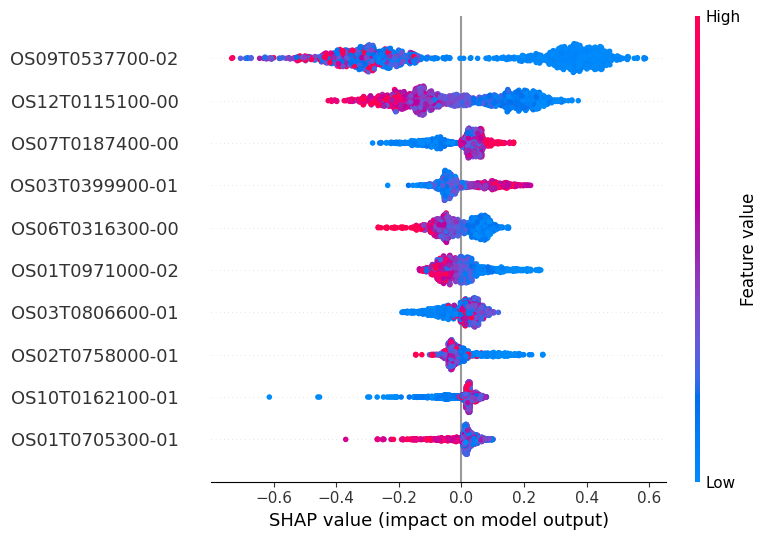

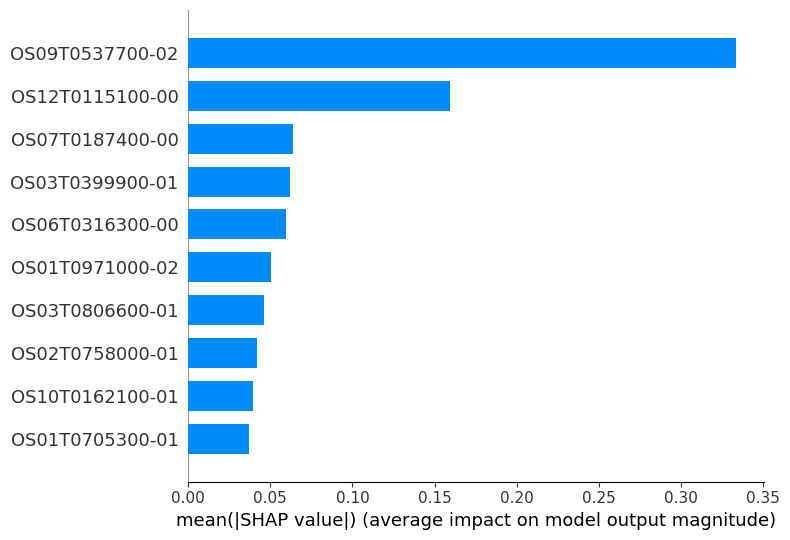

In [4]:
import shap
import matplotlib.pyplot as plt

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 使用训练好的模型来生成SHAP值
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(X_selected_df)

# 可视化前10个特征的重要性
shap.summary_plot(shap_values, X_selected_df, max_display=10)

# 如果你想要更清晰的单独显示特征重要性的条形图
shap.summary_plot(shap_values, X_selected_df, plot_type="bar", max_display=10)


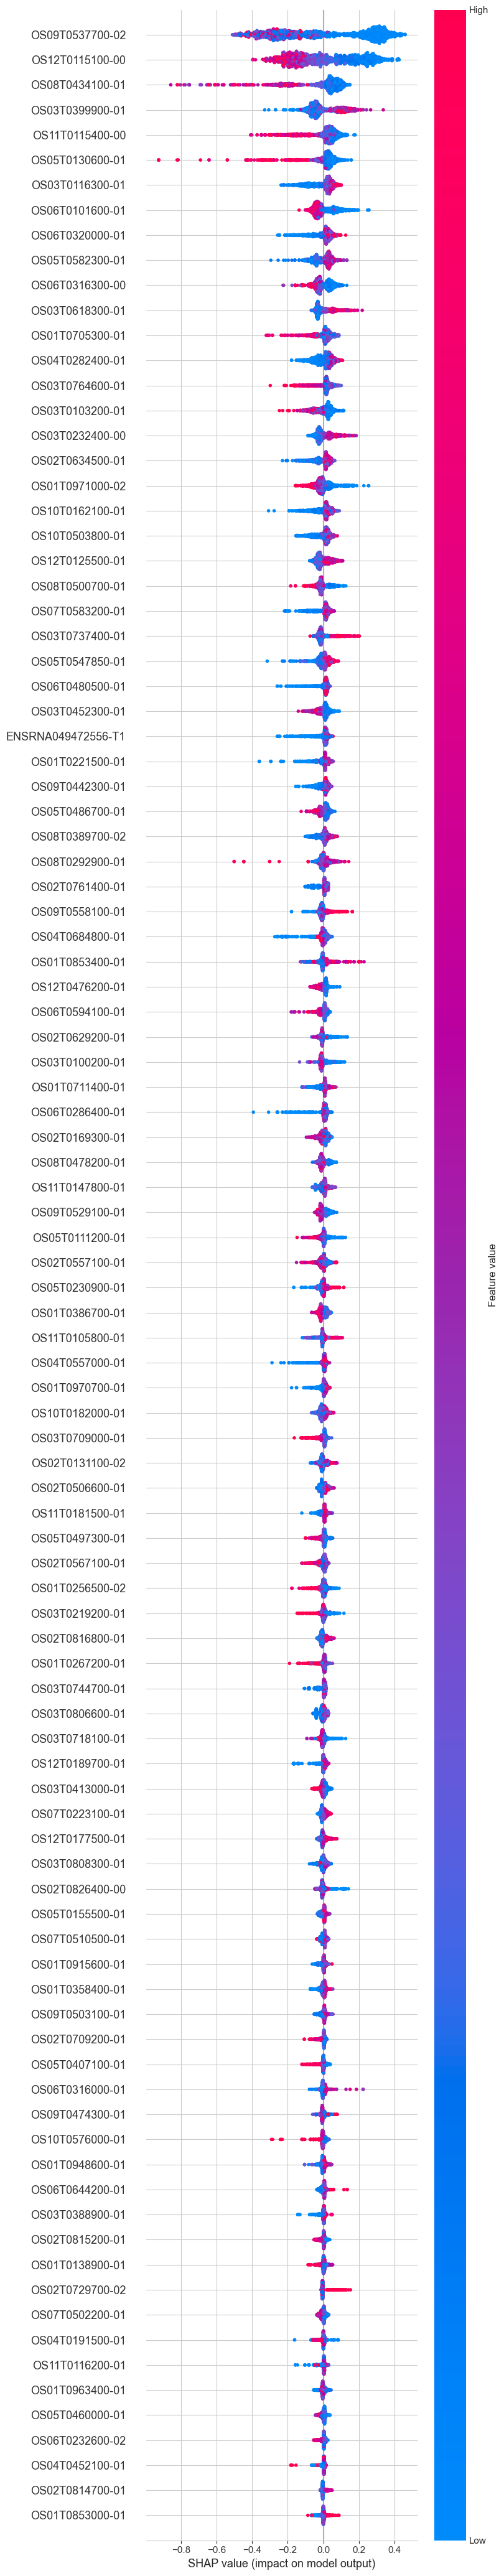

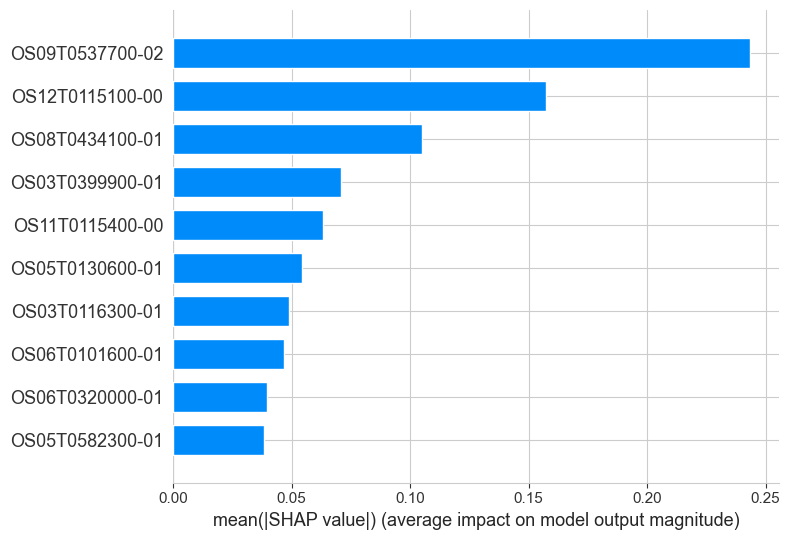

SHAP 特征重要性已保存为 Excel 文件：shap_feature_importance.xlsx


In [11]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 使用训练好的模型来生成SHAP值
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(X_selected_df)

# 可视化前10个特征的重要性
shap.summary_plot(shap_values, X_selected_df, max_display=100)
shap.summary_plot(shap_values, X_selected_df, plot_type="bar", max_display=10)

# 计算每个基因（特征）的平均 SHAP 绝对值，用于排序
shap_importance = pd.DataFrame({
    'gene': X_selected_df.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
})

# 按照重要性排序
shap_importance_sorted = shap_importance.sort_values(by='mean_abs_shap', ascending=False)

# 保存到 Excel 文件
shap_importance_sorted.to_excel('shap_feature_importance.xlsx', index=False)

print("SHAP 特征重要性已保存为 Excel 文件：shap_feature_importance.xlsx")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

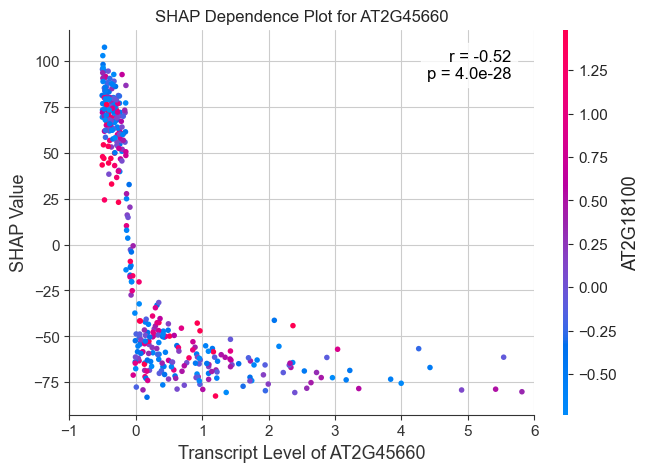

In [5]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT2G45660"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_xgb_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 500

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)

    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

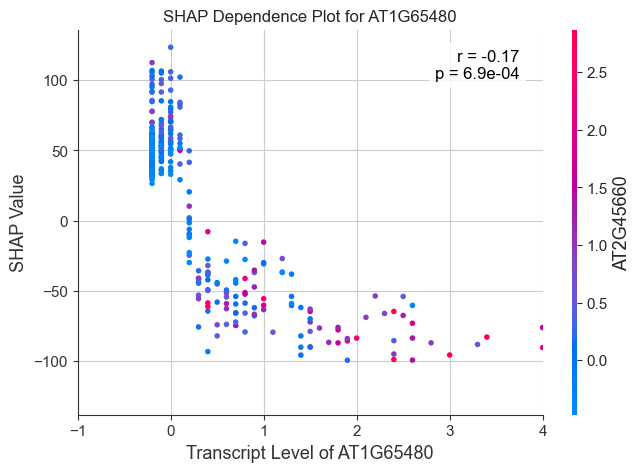

In [6]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT1G65480"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_xgb_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 4)

    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

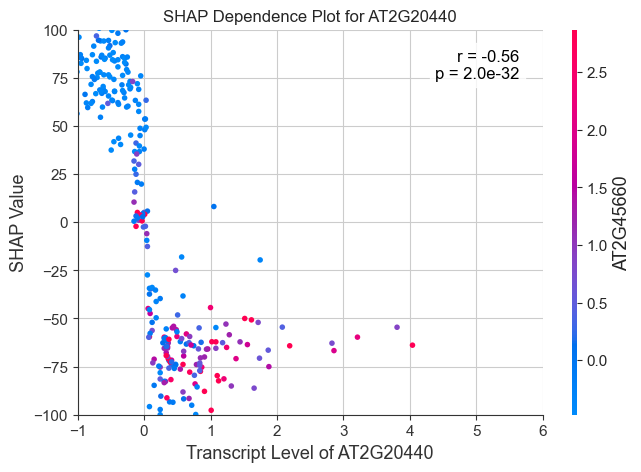

In [7]:
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT2G20440"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_xgb_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values * 1000*5

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)
    plt.ylim(-100, 100)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

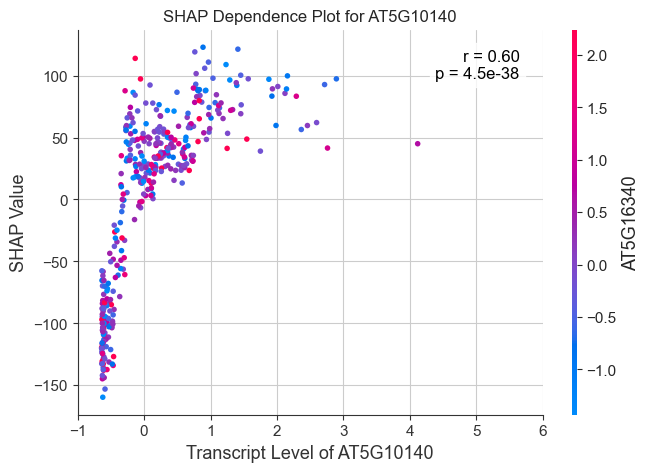

In [19]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT5G10140"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_xgb_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values *2000

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

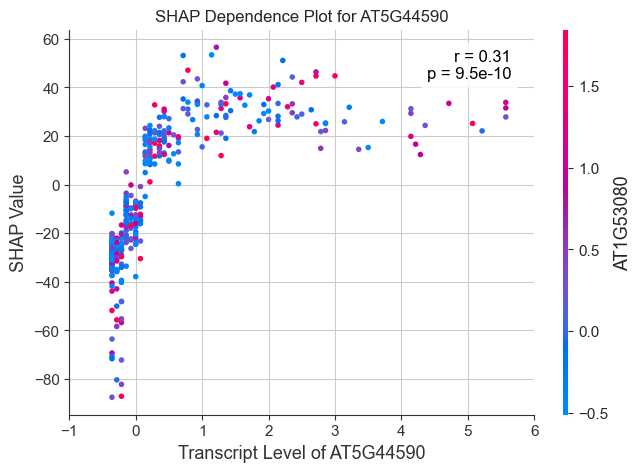

In [20]:
#依赖图
import shap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 假设 X_selected_df 是经过特征选择后的 DataFrame，包含最重要的特征
X_selected_df = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# 你想分析的基因名称
gene_name = "AT5G44590"  # 替换为你想分析的基因名称

# 检查基因是否在选择的特征中
if gene_name in X_selected_df.columns:
    # 使用训练好的模型来生成 SHAP 值
    explainer = shap.Explainer(best_xgb_model)
    shap_values = explainer.shap_values(X_selected_df)

    # 将 SHAP 值乘以 100
    shap_values_scaled = shap_values *2000

    # 获取基因的转录水平
    gene_transcript_level = X_selected_df[gene_name]

    # 获取 Flowering time（目标变量）
    flowering_time = y_transformed

    # 计算相关性 (Pearson Correlation)
    correlation, p_value = pearsonr(gene_transcript_level, flowering_time)

    # 生成特定基因的依赖图
    shap.dependence_plot(gene_name, shap_values_scaled, X_selected_df, show=False)

    # 自定义横坐标范围（x 轴范围设置为 0 到 6）
    plt.xlim(-1, 6)
    # 添加相关性文本到图表右上角
    plt.text(0.95, 0.95, f"r = {correlation:.2f}\np = {p_value:.1e}", ha='right', va='top', 
             transform=plt.gca().transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.8))

    # 显示图表
    plt.title(f"SHAP Dependence Plot for {gene_name}")
    plt.xlabel(f"Transcript Level of {gene_name}")
    plt.ylabel("SHAP Value")
    plt.colorbar(label="SHAP Value")
    plt.show()
else:
    print(f"基因 {gene_name} 不在所选特征中，请检查特征选择步骤。")
